In [1]:
import numpy as np

from scipy.special import lambertw

import sympy

from regions import CirclePixelRegion, PixCoord, RectanglePixelRegion, CirclePixelRegion, PolygonPixelRegion

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

See [exp_gen_experiments](exp_gen_experiments.ipynb) for function tests and derivations

In [3]:
BVAL = 1.6783469900166605 
TWOPI = 2*np.pi

In [4]:
def generate_unif_box(n=None, halfsize=1, density=None, rstate=np.random.RandomState()):
    if n is not None and density is not None:
        raise ValueError('cannot give both n and density')
    elif density is not None:
        A = (halfsize*2)**2
        n = density * A
        
    if n != int(n):
        remainder = n - int(n)
        n = int(n)
        if np.random.rand(1)[0] < remainder:
            n += 1
    else:
        n = int(n)
        
    x = rstate.uniform(-halfsize, halfsize, n)
    y = rstate.uniform(-halfsize, halfsize, n)

    return x, y

def uniform_in_region(density, region, rstate=np.random.RandomState()):
    maxpx = np.max(region.bounding_box.extent)
    xs, ys = generate_unif_box(halfsize=maxpx, density=density, rstate=rstate)
    msk = region.contains(PixCoord(xs, ys))

    return xs[msk], ys[msk]

def expinteg(F, Re, b=BVAL):
    sc = np.isscalar(F)
    res = np.atleast_1d(-Re*(lambertw((F-1)/np.exp(1), -1).real + 1)/b)
    res.ravel()[np.isnan(res.ravel())] = 0
    return res[0] if sc else res
    
def generate_exp_dglx(n=None, Re=1, density=None, region=None, rstate=np.random.RandomState()):
    if n is not None and density is not None:
        raise ValueError('cannot give both n and density')
    elif density is not None:
        # density is the mean density within the HLR
        hA = np.pi*Re**2
        n = 2* density * hA
        
    if n != int(n):
        remainder = n - int(n)
        n = int(n)
        if np.random.rand(1)[0] < remainder:
            n += 1
    else:
        n = int(n)
        
    U = rstate.uniform(0, 1, n)
    r = expinteg(U, Re)
    phi = rstate.uniform(0, 2*np.pi, n)

    x = np.cos(phi)*r
    y = np.sin(phi)*r

    if region is not None:
        msk = region.contains(PixCoord(x, y))
        x = x[msk]
        y = y[msk]

    return x, y

In [5]:
def glx_and_uniform(glx_hdensity, bkg_density, region, Re=1, rstate=np.random.RandomState()):
    g = generate_exp_dglx(density=glx_hdensity, Re=Re, region=region, rstate=rstate)
    b = uniform_in_region(bkg_density, region=region, rstate=rstate)

    return np.concatenate((g, b), axis=1), g, b

(-10.0, 10.0)

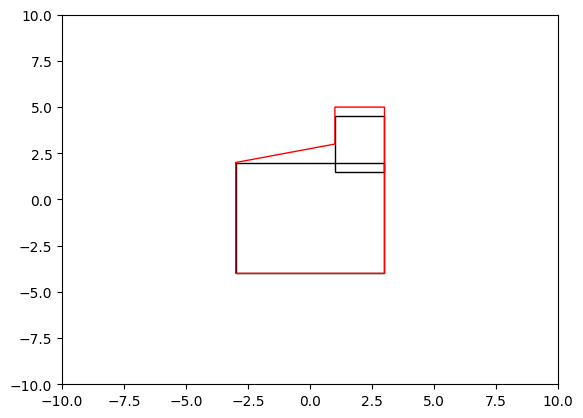

In [6]:
offset_region1 = RectanglePixelRegion(PixCoord(2, 3), 2, 3)
offset_region2 = RectanglePixelRegion(PixCoord(0, -1), 6, 6)
poly_region = PolygonPixelRegion(PixCoord([-3, -3, 3, 3, 1, 1, -3], [2, -4, -4, 5, 5, 3, 2]))

offset_region1.plot()
offset_region2.plot()
poly_region.plot(color='red')
plt.xlim(-10, 10)
plt.ylim(-10, 10)

In [7]:
circular_large_reg = CirclePixelRegion(PixCoord(0, 0), 10)
circular_small_reg = CirclePixelRegion(PixCoord(0, 0), 3)
rectangular_large_reg = RectanglePixelRegion(PixCoord(0, 0), 20, 20)
rectangular_small_reg = RectanglePixelRegion(PixCoord(0, 0), 6, 6)

offset_region1 = RectanglePixelRegion(PixCoord(2, 3), 2, 3)
offset_region2 = RectanglePixelRegion(PixCoord(0, -1), 6, 6)
offset_regions = offset_region1 | offset_region2

offset_poly_region = PolygonPixelRegion(PixCoord([-3, -3, 3, 3, 1, 1, -3], [2, -4, -4, 5, 5, 3, 2]))

all_regions = {nm: globals()[nm] for nm in 'circular_large_reg,circular_small_reg,rectangular_large_reg,rectangular_small_reg,offset_poly_region'.split(',')}

# Set up fitting code

`region` is a fixed region - if None the integrals are implied to infity.

Parameters:
* x0, y0 -> center
* Re -> half-light radius
* fbkg -> background fraction of all the stars

In [8]:
import dynesty
from dynesty import plotting as dyplot

param_names = 'x0, y0, Re, fbkg'.split(', ')

Derive the bounded scale-free prior generator

In [9]:
σ, x, a, b, A, F = sympy.symbols('σ,x,a,b,A,F', real=True, positive=True)
Asoln = sympy.solve(sympy.integrate(A/σ,(σ,a,b)) - 1, A)[0]
sympy.solve(sympy.integrate(A/σ,(σ,a,x)).subs(A, Asoln) - F, x)[0]

a**(1 - F)*b**F

Prior below is that x0, y0 are on U[-1, 1], Re is scale-free on [.01, 100], fbkg is U[.1, .9]

In [10]:
uppri = 100
lpri = .01

def prior_transform(u):
    x = np.empty_like(u)
    x[:2] = u[:2]*2 -1
    x[2] = lpri**(1-u[2]) * uppri**u[2]
    x[3] = u[3]*.8 + .1

    return x

In [11]:
test_region = circular_large_reg
test_data, tg, tb = glx_and_uniform(25, 2, test_region)
truths = [0, 0, 1, -1]

truths[-1] = len(tb[0])/(len(tb[0]) + len(tg[0]))

len(tg[0]), len(tb[0]), truths[-1]

(158, 644, 0.8029925187032418)

In [12]:
LTWOPI = np.log(TWOPI)

def loglike(p, data, area):
    x0, y0, Re, fbkg = p
    x, y = data
    α = Re/BVAL

    r = np.hypot(x-x0, y-y0)
    lgal = np.log(1-fbkg) - 2*np.log(α) - r/α - LTWOPI
    lbkg = np.log(fbkg/area)
    ll = np.logaddexp(lgal, lbkg)

    return np.sum(ll)
    

In [13]:
with dynesty.pool.Pool(16, loglike, prior_transform,
                                logl_kwargs={'data': test_data, 'area':test_region.area},
                      ) as pool:
    dsampler = dynesty.DynamicNestedSampler(pool.loglike, pool.prior_transform, pool=pool,
                                            ndim=len(param_names),sample='rslice')
    dsampler.run_nested(maxiter=100000,  wt_kwargs={'pfrac': 1.0})

16112it [00:11, 1446.61it/s, batch: 6 | bound: 10 | nc: 1 | ncall: 506385 | eff(%):  3.075 | loglstar: -4449.136 < -4443.595 < -4444.400 | logz: -4454.289 +/-  0.089 | stop:  0.877]    


/home/erik/.cache/pypoetry/virtualenvs/structparams-inference-biases-aTTQn185-py3.12/lib/python3.12/site-packages/dynesty/plotting.py:318: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


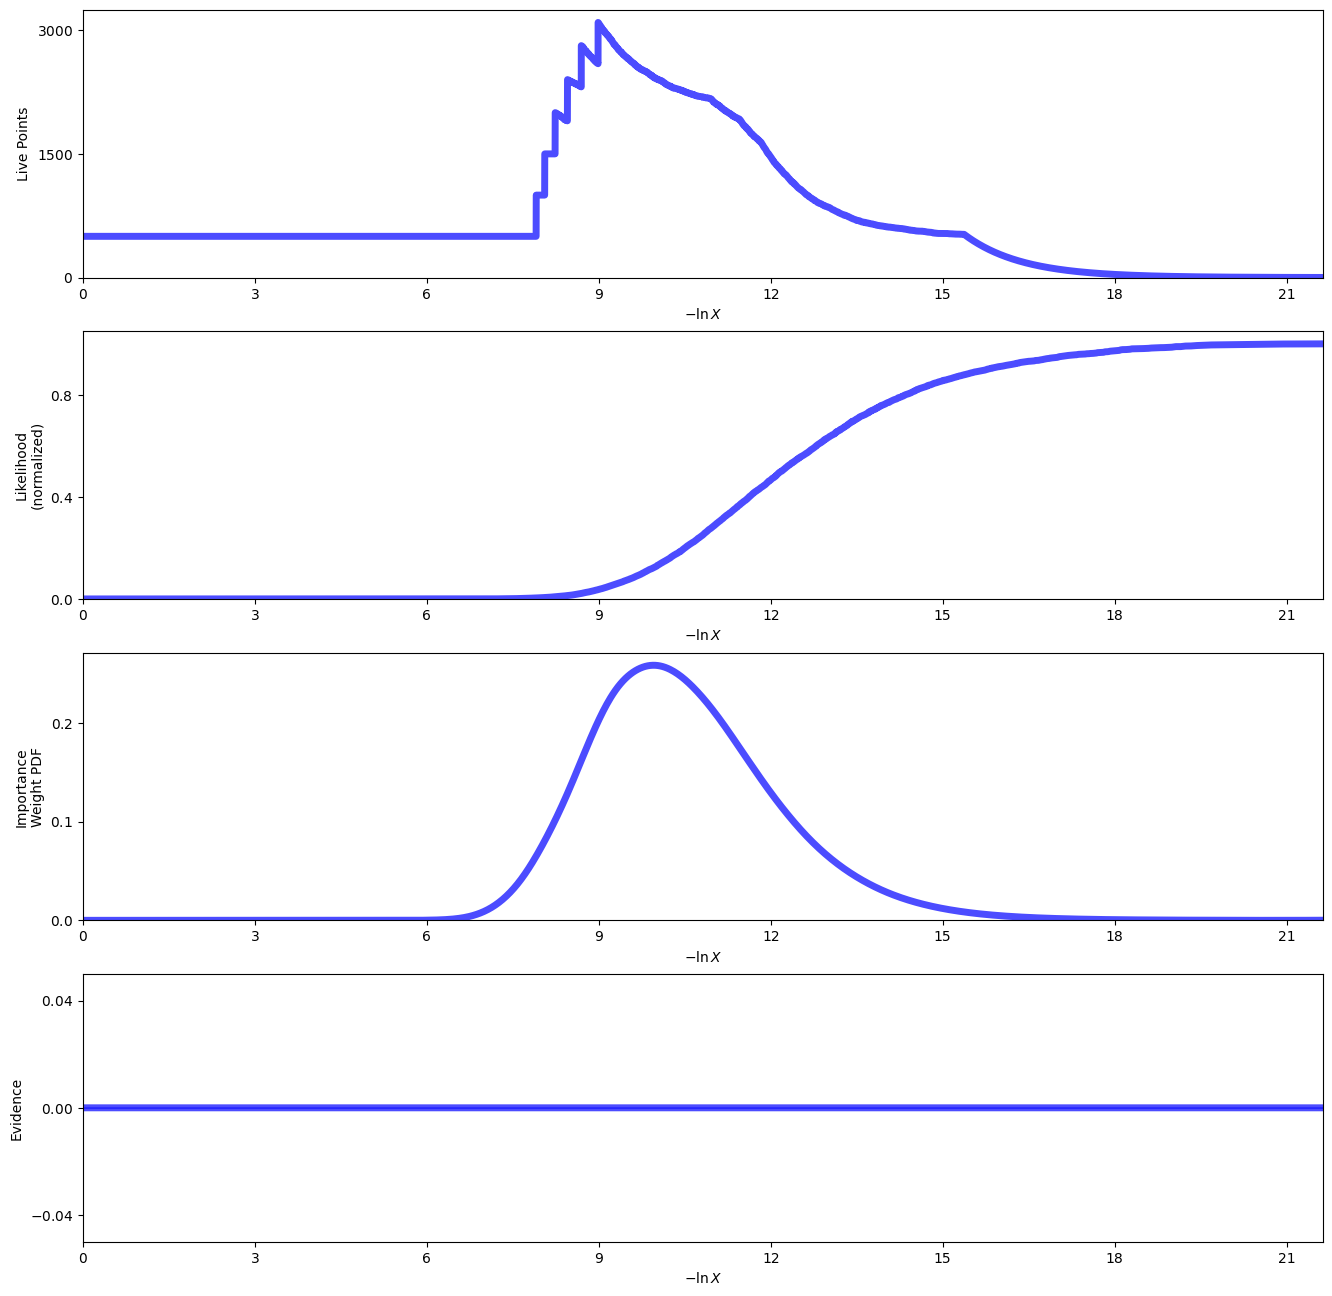

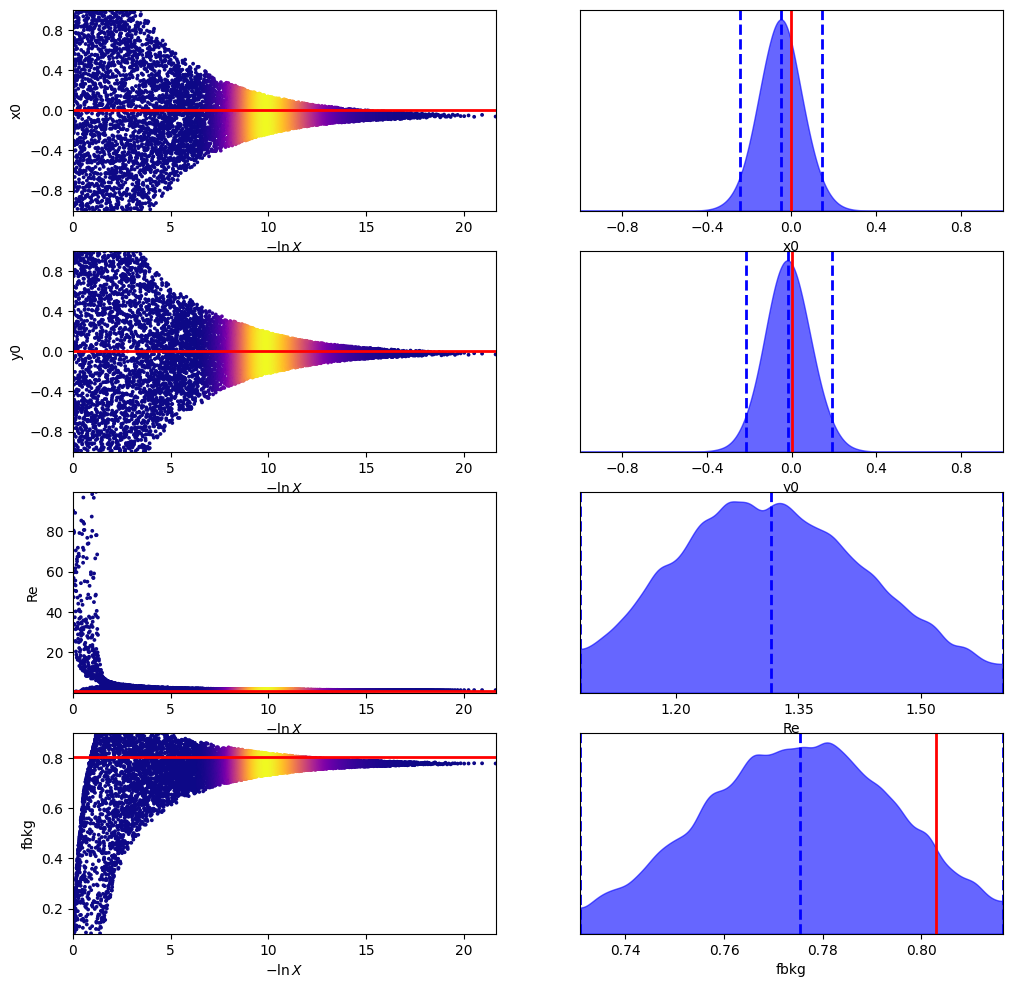

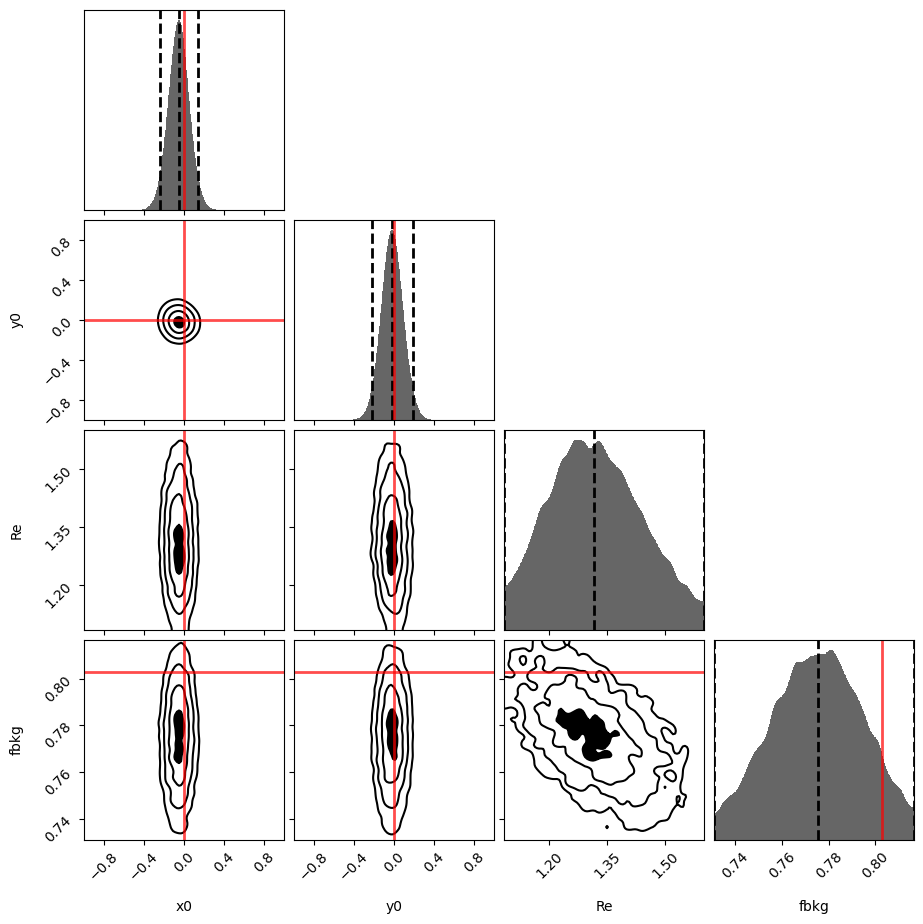

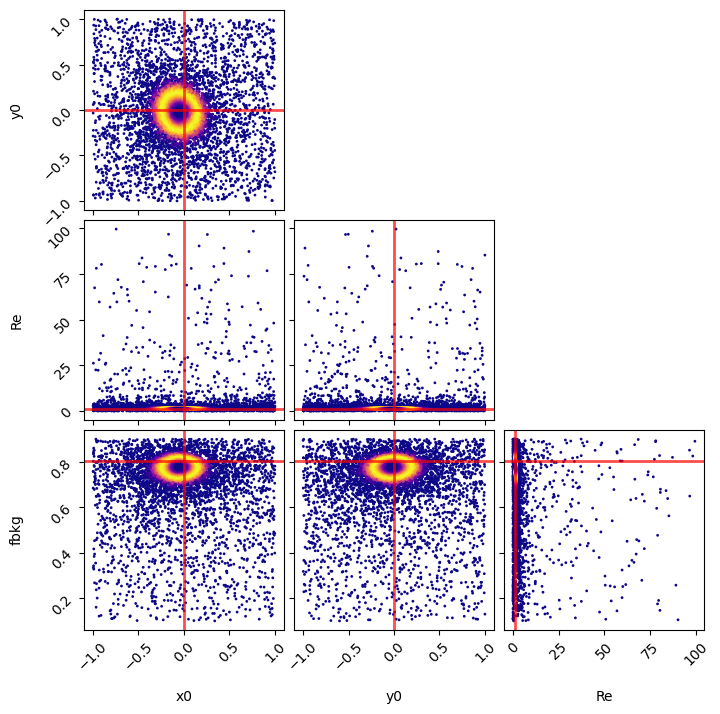

In [14]:
fig, axes = dyplot.runplot(dsampler.results)

span = [1,1, .95, .95]

fig, axes = dyplot.traceplot(dsampler.results, labels=param_names, truths=truths,span=span)
fig, axes = dyplot.cornerplot(dsampler.results, labels=param_names, truths=truths,span=span)
fig, axes = dyplot.cornerpoints(dsampler.results, labels=param_names, truths=truths)

In [15]:
results = {}
truths = {}
for regnm, test_region in all_regions.items():
    print(regnm)
    
    test_data, tg, tb = glx_and_uniform(25, 2, test_region)
    truths[regnm] = [0, 0, 1, len(tb[0])/(len(tb[0]) + len(tg[0]))]

    with dynesty.pool.Pool(16, loglike, prior_transform,
                                logl_kwargs={'data': test_data, 'area':test_region.area},
                      ) as pool:
        dsampler = dynesty.DynamicNestedSampler(pool.loglike, pool.prior_transform, pool=pool,
                                                ndim=len(param_names),sample='rslice')
        dsampler.run_nested(maxiter=100000,  wt_kwargs={'pfrac': 1.0})
    results[regnm] = dsampler.results

circular_large_reg


16874it [00:11, 1408.34it/s, batch: 7 | bound: 9 | nc: 1 | ncall: 534442 | eff(%):  3.058 | loglstar: -4225.787 < -4220.240 < -4221.138 | logz: -4231.684 +/-  0.089 | stop:  0.857]     


circular_small_reg


16703it [00:10, 1593.63it/s, batch: 7 | bound: 10 | nc: 1 | ncall: 530497 | eff(%):  3.048 | loglstar: -644.099 < -638.385 < -639.244 | logz: -648.446 +/-  0.081 | stop:  0.823]      

rectangular_large_reg



15861it [00:11, 1332.18it/s, batch: 6 | bound: 9 | nc: 1 | ncall: 496069 | eff(%):  3.088 | loglstar: -5631.151 < -5625.813 < -5626.776 | logz: -5636.934 +/-  0.091 | stop:  0.914]     

rectangular_small_reg



15391it [00:10, 1497.20it/s, batch: 6 | bound: 7 | nc: 1 | ncall: 479298 | eff(%):  3.098 | loglstar: -706.279 < -701.100 < -702.490 | logz: -711.229 +/-  0.085 | stop:  0.917]       


offset_poly_region


15548it [00:10, 1449.59it/s, batch: 6 | bound: 7 | nc: 1 | ncall: 485301 | eff(%):  3.092 | loglstar: -861.294 < -856.056 < -857.443 | logz: -866.644 +/-  0.087 | stop:  0.922]       


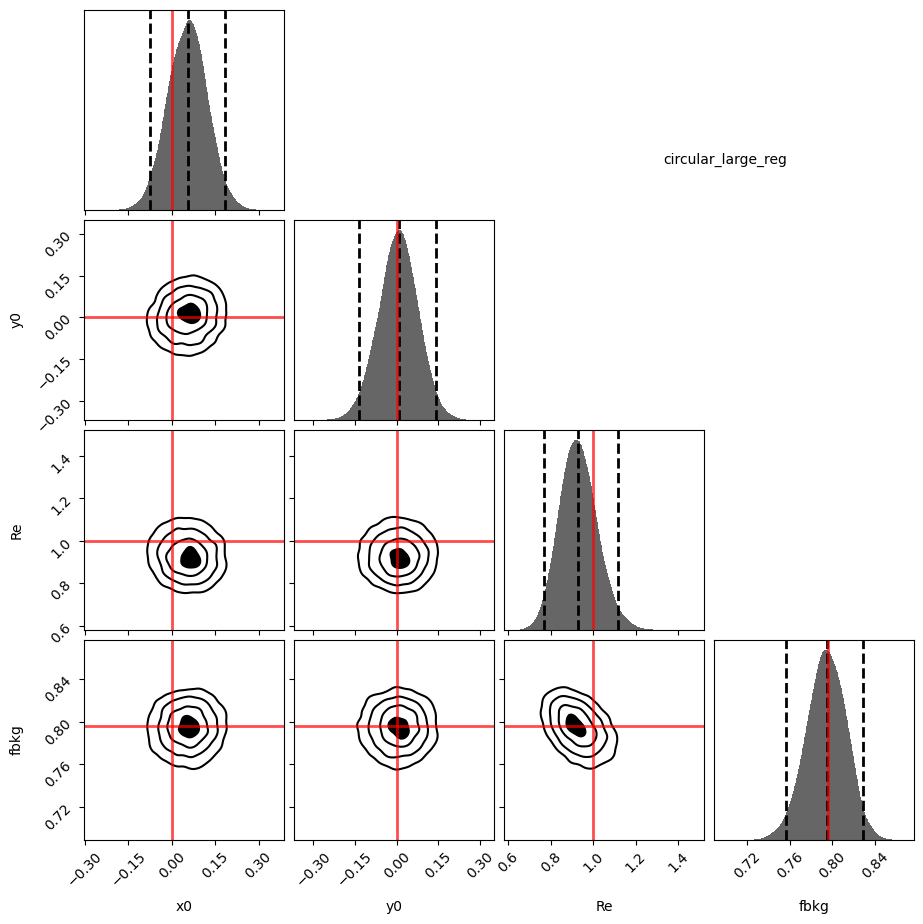

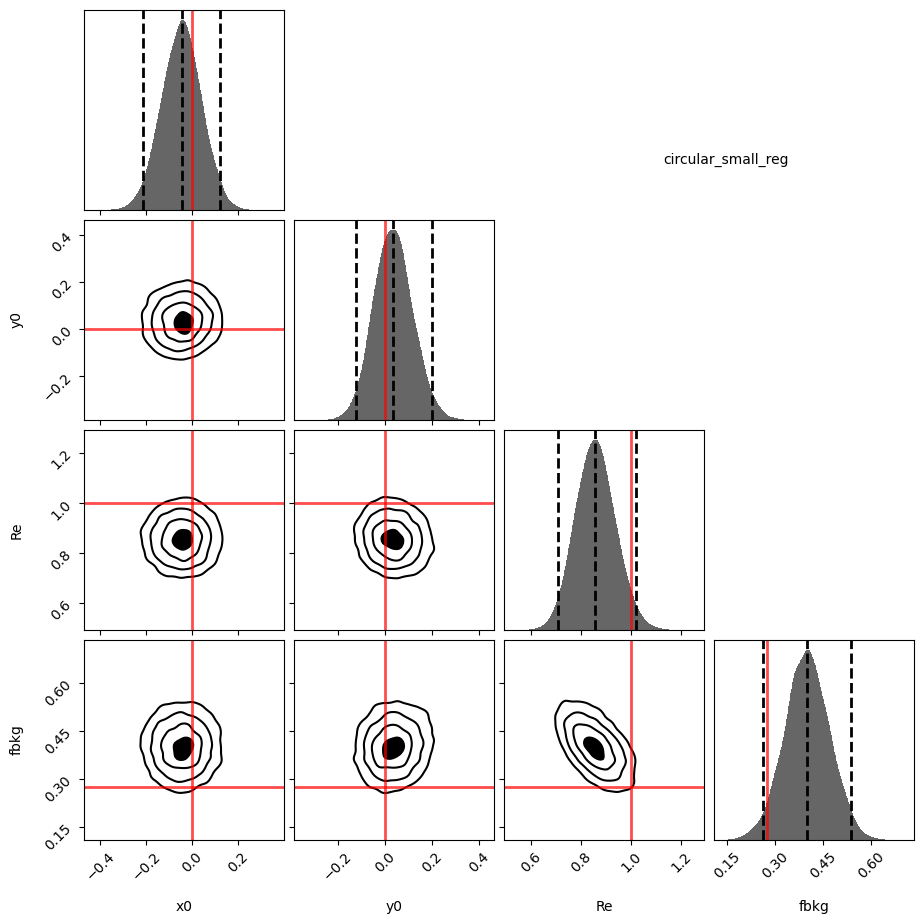

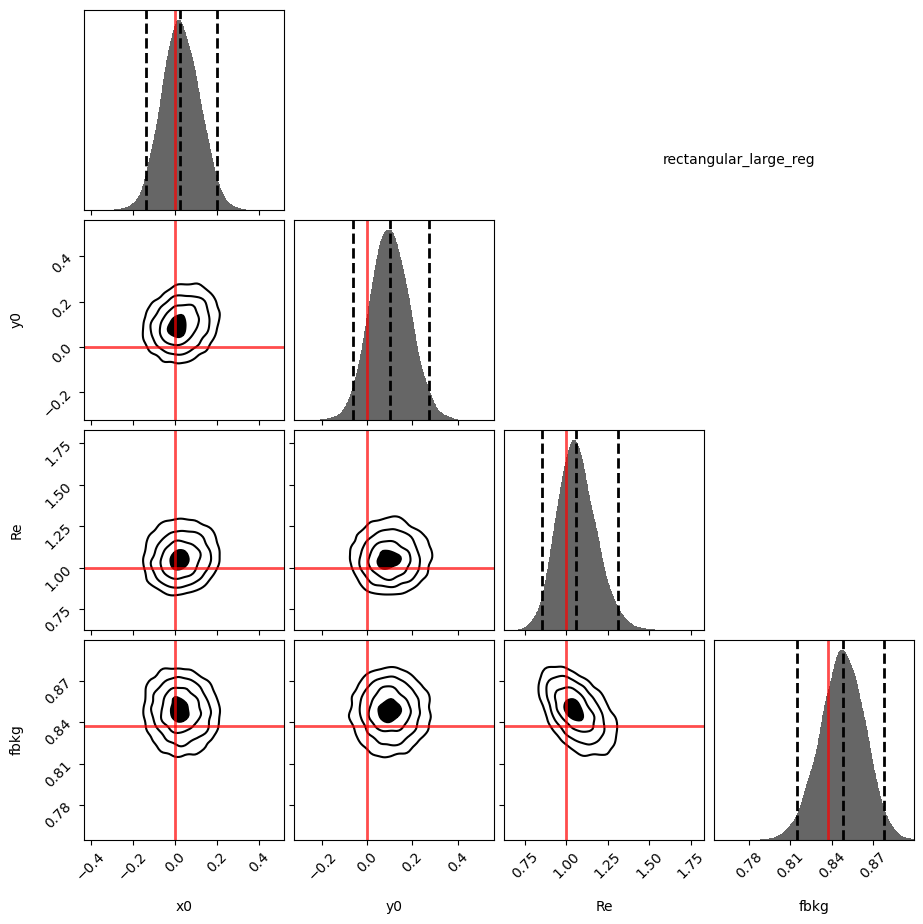

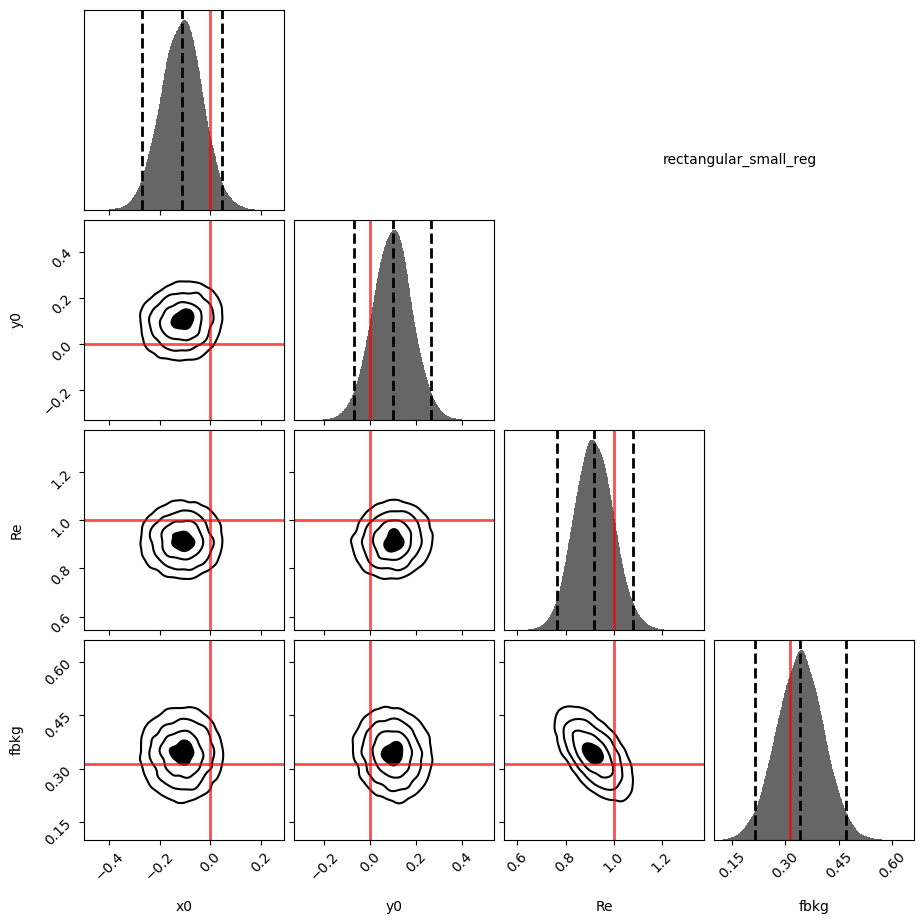

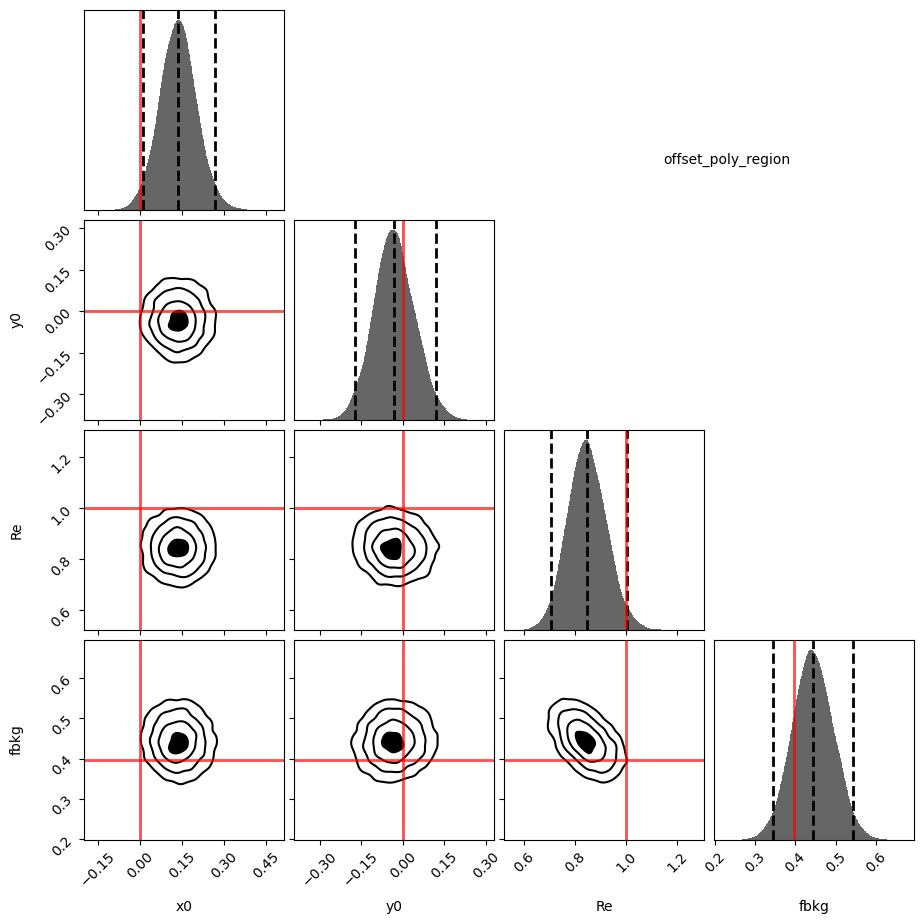

In [16]:
for nm, res in results.items():
    fig, axes = dyplot.cornerplot(res, labels=param_names, truths=truths[nm])
    axes[0][0].text(.7,.8, nm, transform=fig.transFigure)